In [1]:
import seaborn as sns
from sklearn.metrics import classification_report
from joblib import dump, load
from sklearn.decomposition import PCA
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegressionCV
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from keras.models import load_model
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import OneHotEncoder

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dropout, Flatten, Dense

import pandas as pd
import traceback
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

Using TensorFlow backend.


# Data Preprocessing

In [2]:
UTK_path = '../Data/UTKFace/'
def read_UTK(startpath):
    X = []
    y = []
    try:
        for root, dirs, files in os.walk(startpath):
            for file in files:
                if file[-3:] == 'jpg':
                    names = file.split('_')
                    if int(names[0]) > 17 and int(names[0]) < 30:

                        y.append(names[1])
                        img = cv2.imread(root + file, cv2.IMREAD_GRAYSCALE)
                        X.append(img)

    except Exception as err:
        traceback.print_tb(err.__traceback__)
    X, y = np.array(X, dtype='float'), np.array(y, dtype='uint8')
    X = np.expand_dims(X, -1)
    oht = OneHotEncoder(categories='auto', sparse=False)
    y = oht.fit_transform(y.reshape(-1, 1))
    X_train, X_test, y_train, y_test = train_test_split(X, y)
    return X_train, X_test, y_train, y_test

In [3]:
y_translation = {
    0: 'Male',
    1: 'Female',
}
X_train, X_test, y_train, y_test = read_UTK(UTK_path)
classes = 2
inputShape = (200, 200, 1)

In [4]:
training_errors = []
testing_errors = []

# Keras Neural Network

In [5]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=inputShape, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(classes, activation='softmax'))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [6]:
model.compile(optimizer='adam', loss='binary_crossentropy',
              metrics=['accuracy'])

In [7]:
# model.fit(X_train, y_train, batch_size=200, epochs=12)

In [8]:
model = load_model('../Models/gender_classifier_model')
# model.save('gender_classifier_model')

Instructions for updating:
Use tf.cast instead.


In [9]:
loss, acc = model.evaluate(X_train, y_train, verbose=0)
print('Training loss: {}, acc: {}\n'.format(loss, acc))
training_errors.append(acc)

loss, acc = model.evaluate(X_test, y_test, verbose=0)
print('Testing loss: {}, acc: {}\n'.format(loss, acc))
testing_errors.append(acc)

Training loss: 0.08777991641543653, acc: 0.971616476310005

Testing loss: 0.09959827564503931, acc: 0.9719626168224299



# Reducing data dimensions for SVM, PCA and NB

In [10]:
pca = PCA(100)
X_train_reduced_100 = pca.fit_transform(X_train.reshape(X_train.shape[0], -1))
X_test_reduced_100 = pca.transform(X_test.reshape(X_test.shape[0], -1))

pca = PCA(50)
X_train_reduced_50 = pca.fit_transform(X_train.reshape(X_train.shape[0], -1))
X_test_reduced_50 = pca.transform(X_test.reshape(X_test.shape[0], -1))

pca = PCA(20)
X_train_reduced_20 = pca.fit_transform(X_train.reshape(X_train.shape[0], -1))
X_test_reduced_20 = pca.transform(X_test.reshape(X_test.shape[0], -1))

### SVM on Reduced Data

In [11]:
svc = SVC()
logreg = LogisticRegressionCV(max_iter=500)
nb = BernoulliNB()

In [12]:
svc.fit(X_train_reduced_100, np.argmax(y_train, axis=1))
training_errors.append(svc.score(X_train_reduced_100, np.argmax(y_train, axis=1)))
testing_errors.append(svc.score(X_test_reduced_100, np.argmax(y_test, axis=1)))

/home/jatin/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


### Logistic Regression on Reduced Data

In [13]:
logreg.fit(X_train_reduced_100, np.argmax(y_train, axis=1))
training_errors.append(logreg.score(X_train_reduced_100, np.argmax(y_train, axis=1)))
testing_errors.append(logreg.score(X_test_reduced_100, np.argmax(y_test, axis=1)))


/home/jatin/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


### Naive Bayes on Reduced Data

In [14]:
nb.fit(X_train_reduced_100, np.argmax(y_train, axis=1))
training_errors.append(nb.score(X_train_reduced_100, np.argmax(y_train, axis=1)))
testing_errors.append(nb.score(X_test_reduced_100, np.argmax(y_test, axis=1)))


### running grid search on a smaller sampled size

In [29]:
_, X_grid_train, _, y_grid_train = train_test_split(
    X_train_reduced_20, np.argmax(y_train, axis=1), test_size=0.01)

In [33]:
np.unique(y_grid_train, return_counts=True)

(array([0, 1]), array([23, 35]))

In [34]:
tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                     'C': [1, 10, 100, 1000]},
                    {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]

scores = ['accuracy']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(SVC(), tuned_parameters, cv=5,
                       scoring=score)
    clf.fit(X_grid_train, y_grid_train)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = np.argmax(y_test, axis=1), clf.predict(X_test_reduced_20)
    print(classification_report(y_true, y_pred))
    print()

# Note the problem is too easy: the hyperparameter plateau is too flat and the
# output model is the same for precision and recall with ties in quality.

# Tuning hyper-parameters for accuracy



/Users/visheshhemnani/anaconda3/envs/ml_proj/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'kernel': ['rbf'], 'gamma': [0.001, 0.0001], 'C': [1, 10, 100, 1000]}, {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

Best parameters set found on development set:

{'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}

Grid scores on development set:

0.603 (+/-0.051) for {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}
0.603 (+/-0.051) for {'C': 1, 'gamma': 0.0001, 'kernel': 'rbf'}
0.603 (+/-0.051) for {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
0.603 (+/-0.051) for {'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}
0.603 (+/-0.051) for {'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}
0.603 (+/-0.051) for {'C': 100, 'gamma': 0.0001, 'kernel': 'rbf'}
0.603 (+/-0.051) for {'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}
0.603 (+/-0.051) for {'C': 1000, 'gamma': 0.0001, 'kernel': 'rbf'}
0.466 (+/-0.250) for {'C': 1, 'kernel': 'linear'}
0.431 (+/-0.235) for {'C': 10, 'kernel': 'linear'}
0.431 (+/-0.235) for {'C': 100, 'kernel': 'linear'}
0.431 (+/-0.235) for {'C': 1000, 'kernel': 'linear'}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

              

/Users/visheshhemnani/anaconda3/envs/ml_proj/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [35]:
final_model = clf.best_estimator_

In [50]:
final_model.fit(X_train_reduced_100, np.argmax(y_train, axis=1))

SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [51]:
final_model.score(X_test_reduced_100, np.argmax(y_test, axis=1))

0.5830737279335411

# Barplot for accuracy observations

In [141]:
model_names = ["NeuralNet", "SVM","LogReg","NaiveBayes"]
training_acc_df = pd.DataFrame(training_errors ,columns=['accuracy'])
training_acc_df['type'] = "Training"
training_acc_df['model'] = model_names
testing_acc_df = pd.DataFrame(testing_errors,columns=['accuracy'])
testing_acc_df['type'] = "Testing"
testing_acc_df['model'] = model_names
acc_df = pd.concat([training_acc_df, testing_acc_df])
acc_df['accuracy'] = acc_df['accuracy']*100

In [143]:
acc_df

,accuracy,type,model
0,97.248183,Training,NeuralNet
1,99.792316,Training,SVM
2,91.225337,Training,LogReg
3,80.910350,Training,NaiveBayes
0,96.936656,Testing,NeuralNet
1,58.307373,Testing,SVM
2,90.238837,Testing,LogReg
3,78.868120,Testing,NaiveBayes


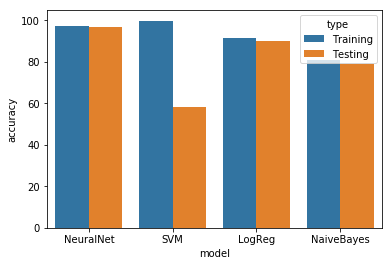

In [145]:
ax = sns.barplot(x = 'model',y = "accuracy",hue="type", data=acc_df)
